In [26]:
import sys
from konlpy.tag import Okt
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt    

In [2]:
def save_txt(output):
    sys.stdout = open('./data/output.txt', 'w')
    print(output)
    
    sys.stdout.close()

In [4]:
output = '3주차부터 있을 주제 발표 시간에 발표 순서를 공지합니다. 주제에 대한 소개 (문제 정의) 및 관련 선행 기술 (문제 해결을 위한 기존 제품 및 솔루션)에 대해서 조별로 10분 내외 발표하는 시간입니다.- 3주차 화 (3월 16일): 1~6조 (tentative)- 3주차 목 (3월 18일): 7~12조 (tentative)- 4주차 화 (3월 23일): 13~19조 (tentative)- 4주차 목 (3월 18일): 19~26조 (tentative)발표는 zoom을 통해서 수업시간에 실시간으로 진행할 예정입니다. zoom 접속 정보는 추후 공지하겠습니다.spread sheet에서 자신이 몇조인지 확인하실 수 있습니다. '

In [35]:
def extractor(output):
    okt = Okt()
    noun = okt.nouns(output)
    count = Counter(noun)
    
    noun_list = count.most_common(100)
    print(sorted(count.items(), key=lambda kv : kv[1], reverse=True)[:3])
    
    wc = WordCloud(font_path='C:/Users/comso/Desktop/테트리스M.ttf', background_color="white", width=1000, height=1000, max_words=100, max_font_size=300)
    wc.generate(output)
    plt.figure(figsize=(10, 8))
    plt.imshow(wc)
    plt.tight_layout(pad=0)
    plt.axis('off')
    plt.show()
    wc.to_file('wordcloud_outputs.png')

[('주차', 5), ('발표', 4), ('시간', 3)]


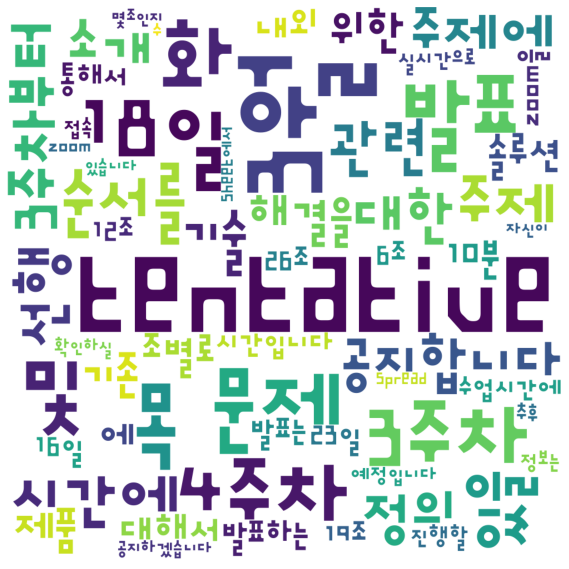

In [36]:
extractor(output)

In [37]:
import networkx
import re

In [38]:
class RawSentence:
    def __init__(self, textIter):
        if type(textIter) == str: self.textIter = textIter.split('\n')
        else: self.textIter = textIter
        self.rgxSplitter = re.compile('([.!?:](?:["\']|(?![0-9])))')
 
    def __iter__(self):
        for line in self.textIter:
            ch = self.rgxSplitter.split(line)
            for s in map(lambda a, b: a + b, ch[::2], ch[1::2]):
                if not s: continue
                yield s

In [39]:
class RawSentenceReader:
    def __init__(self, filepath):
        self.filepath = filepath
        self.rgxSplitter = re.compile('([.!?:](?:["\']|(?![0-9])))')
 
    def __iter__(self):
        for line in open(self.filepath, encoding='utf-8'):
            ch = self.rgxSplitter.split(line)
            for s in map(lambda a, b: a + b, ch[::2], ch[1::2]):
                if not s: continue
                yield s

In [40]:
class RawTagger:
    def __init__(self, textIter, tagger = None):
        if tagger:
            self.tagger = tagger
        else :
            from konlpy.tag import Komoran
            self.tagger = Komoran()
        if type(textIter) == str: self.textIter = textIter.split('\n')
        else: self.textIter = textIter
        self.rgxSplitter = re.compile('([.!?:](?:["\']|(?![0-9])))')
 
    def __iter__(self):
        for line in self.textIter:
            ch = self.rgxSplitter.split(line)
            for s in map(lambda a,b:a+b, ch[::2], ch[1::2]):
                if not s: continue
                yield self.tagger.pos(s)

In [41]:
class RawTaggerReader:
    def __init__(self, filepath, tagger = None):
        if tagger:
            self.tagger = tagger
        else :
            from konlpy.tag import Komoran
            self.tagger = Komoran()
        self.filepath = filepath
        self.rgxSplitter = re.compile('([.!?:](?:["\']|(?![0-9])))')
 
    def __iter__(self):
        for line in open(self.filepath, encoding='utf-8'):
            ch = self.rgxSplitter.split(line)
            for s in map(lambda a,b:a+b, ch[::2], ch[1::2]):
                if not s: continue
                yield self.tagger.pos(s)

In [42]:
class TextRank:
    def __init__(self, **kargs):
        self.graph = None
        self.window = kargs.get('window', 5)
        self.coef = kargs.get('coef', 1.0)
        self.threshold = kargs.get('threshold', 0.005)
        self.dictCount = {}
        self.dictBiCount = {}
        self.dictNear = {}
        self.nTotal = 0
 
 
    def load(self, sentenceIter, wordFilter = None):
        def insertPair(a, b):
            if a > b: a, b = b, a
            elif a == b: return
            self.dictBiCount[a, b] = self.dictBiCount.get((a, b), 0) + 1
 
        def insertNearPair(a, b):
            self.dictNear[a, b] = self.dictNear.get((a, b), 0) + 1
 
        for sent in sentenceIter:
            for i, word in enumerate(sent):
                if wordFilter and not wordFilter(word): continue
                self.dictCount[word] = self.dictCount.get(word, 0) + 1
                self.nTotal += 1
                if i - 1 >= 0 and (not wordFilter or wordFilter(sent[i-1])): insertNearPair(sent[i-1], word)
                if i + 1 < len(sent) and (not wordFilter or wordFilter(sent[i+1])): insertNearPair(word, sent[i+1])
                for j in range(i+1, min(i+self.window+1, len(sent))):
                    if wordFilter and not wordFilter(sent[j]): continue
                    if sent[j] != word: insertPair(word, sent[j])
 
    def loadSents(self, sentenceIter, tokenizer = None):
        import math
        def similarity(a, b):
            n = len(a.intersection(b))
            return n / float(len(a) + len(b) - n) / (math.log(len(a)+1) * math.log(len(b)+1))
 
        if not tokenizer: rgxSplitter = re.compile('[\\s.,:;-?!()"\']+')
        sentSet = []
        for sent in filter(None, sentenceIter):
            if type(sent) == str:
                if tokenizer: s = set(filter(None, tokenizer(sent)))
                else: s = set(filter(None, rgxSplitter.split(sent)))
            else: s = set(sent)
            if len(s) < 2: continue
            self.dictCount[len(self.dictCount)] = sent
            sentSet.append(s)
 
        for i in range(len(self.dictCount)):
            for j in range(i+1, len(self.dictCount)):
                s = similarity(sentSet[i], sentSet[j])
                if s < self.threshold: continue
                self.dictBiCount[i, j] = s
 
    def getPMI(self, a, b):
        import math
        co = self.dictNear.get((a, b), 0)
        if not co: return None
        return math.log(float(co) * self.nTotal / self.dictCount[a] / self.dictCount[b])
 
    def getI(self, a):
        import math
        if a not in self.dictCount: return None
        return math.log(self.nTotal / self.dictCount[a])
 
    def build(self):
        self.graph = networkx.Graph()
        self.graph.add_nodes_from(self.dictCount.keys())
        for (a, b), n in self.dictBiCount.items():
            self.graph.add_edge(a, b, weight=n*self.coef + (1-self.coef))
 
    def rank(self):
        return networkx.pagerank(self.graph, weight='weight')
 
    def extract(self, ratio = 0.1):
        ranks = self.rank()
        cand = sorted(ranks, key=ranks.get, reverse=True)[:int(len(ranks) * ratio)]
        pairness = {}
        startOf = {}
        tuples = {}
        for k in cand:
            tuples[(k,)] = self.getI(k) * ranks[k]
            for l in cand:
                if k == l: continue
                pmi = self.getPMI(k, l)
                if pmi: pairness[k, l] = pmi
 
        for (k, l) in sorted(pairness, key=pairness.get, reverse=True):
            print(k[0], l[0], pairness[k, l])
            if k not in startOf: startOf[k] = (k, l)
 
        for (k, l), v in pairness.items():
            pmis = v
            rs = ranks[k] * ranks[l]
            path = (k, l)
            tuples[path] = pmis / (len(path) - 1) * rs ** (1 / len(path)) * len(path)
            last = l
            while last in startOf and len(path) < 7:
                if last in path: break
                pmis += pairness[startOf[last]]
                last = startOf[last][1]
                rs *= ranks[last]
                path += (last,)
                tuples[path] = pmis / (len(path) - 1) * rs ** (1 / len(path)) * len(path)
 
        used = set()
        both = {}
        for k in sorted(tuples, key=tuples.get, reverse=True):
            if used.intersection(set(k)): continue
            both[k] = tuples[k]
            for w in k: used.add(w)
 
        #for k in cand:
        #    if k not in used or True: both[k] = ranks[k] * self.getI(k)
 
        return both
 
    def summarize(self, ratio = 0.333):
        r = self.rank()
        ks = sorted(r, key=r.get, reverse=True)[:int(len(r)*ratio)]
        return ' '.join(map(lambda k:self.dictCount[k], sorted(ks)))

In [45]:
tr = TextRank()
print('Load...')
tagger = Okt()
stopword = set([('있', 'VV'), ('하', 'VV'), ('되', 'VV') ])
tr.loadSents(RawSentenceReader('./data/output.txt'), lambda sent: filter(lambda x:x not in stopword and x[1] in ('NNG', 'NNP', 'VV', 'VA'), tagger.pos(sent)))
print('Build...')
tr.build()
ranks = tr.rank()
for k in sorted(ranks, key=ranks.get, reverse=True)[:100]:
    print("\t".join([str(k), str(ranks[k]), str(tr.dictCount[k])]))
print(tr.summarize(0.2))

Load...
Build...



In [47]:
tr = TextRank(window=5, coef=1)
print('Load...')
stopword = set([('있', 'VV'), ('하', 'VV'), ('되', 'VV'), ('없', 'VV') ])
tr.load(RawTaggerReader('./data/output.txt'), lambda w: w not in stopword and (w[1] in ('NNG', 'NNP', 'VV', 'VA')))
print('Build...')
tr.build()
kw = tr.extract(0.1)
for k in sorted(kw, key=kw.get, reverse=True):
    print("%s\t%g" % (k, kw[k]))

Load...
Build...
발표 시간 2.178532444324067
(('발표', 'NNG'), ('시간', 'NNG'))	0.238981
(('주차', 'NNP'),)	0.123591
